# Objectives

## Can we predict and maximize article popularity on social media?
To find out, answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
    * Hypothesis: Shorter articles with shorter titles and shorter words (simpler vocabulary) will garner more shares on average.
* Do certain genres lead to more popular articles? 
    * Hypothesis: Certain genres will receive more shares on average.
* What effect does the day of publication have?
    * Hypothesis: The day of publication will not have an impact on an article's shares.
* Do articles that skew positive, negative, or neutral perform better?
    * Hypothesis: More negative, outrageous (higher subjectivity) articles will be shared more on average.
* What effect do SEO terms have?
    * Hypothesis: Better performing SEO terms (keywords) will have a positive impact on an article's shares.
    
## Approach
Using UCI's [Online News Popularity Data Set](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity), I perform statistical tests to measure the significance of certain variables on the number of social media shares an article receives. During my exploratory data analysis, I create graphs that answer some of my objective questions. I then create a linear regression model, from which I can infer the strongest predictors based on the coefficients within the model.

## Cleaning and exploring the data
* Import the necessary libraries.

In [1]:
import itertools
import numpy as np
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

import pickle

from sklearn import metrics
from sklearn.metrics import mean_squared_error, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

from functions import *

* Import the data.

In [2]:
df = pd.read_csv('data/online_news_popularity.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


* Check out column names.

In [3]:
df.columns

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

* Remove spaces and shorten/clarify some column names.

In [4]:
k = list(df.columns)
v = [column.strip() for column in df.columns]

In [5]:
renamer = dict(zip(k, v))
new_names = {'num_hrefs': 'num_links',
             'num_self_hrefs': 'num_self_links',
             'average_token_length': 'avg_token_length',
             'n_unique_tokens': 'rate_unique_tokens',
             'n_non_stop_words': 'rate_non_stop_words',
             'n_non_stop_unique_tokens': 'rate_non_stop_unique_tokens',
             'data_channel_is_lifestyle': 'lifestyle',
             'data_channel_is_entertainment': 'entertainment',
             'data_channel_is_bus': 'business',
             'data_channel_is_socmed': 'social_media',
             'data_channel_is_tech': 'tech',
             'data_channel_is_world': 'world',
             'self_reference_min_shares': 'self_ref_min_shares',
             'self_reference_max_shares': 'self_ref_max_shares',
             'self_reference_avg_sharess': 'self_ref_avg_shares',
             'weekday_is_monday': 'monday',
             'weekday_is_tuesday': 'tuesday',
             'weekday_is_wednesday': 'wednesday',
             'weekday_is_thursday': 'thursday',
             'weekday_is_friday': 'friday',
             'weekday_is_saturday': 'saturday',
             'weekday_is_sunday': 'sunday',
                }

In [6]:
df.rename(columns=renamer, inplace=True)
df.rename(columns=new_names, inplace=True)

In [7]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'rate_unique_tokens', 'rate_non_stop_words',
       'rate_non_stop_unique_tokens', 'num_links', 'num_self_links',
       'num_imgs', 'num_videos', 'avg_token_length', 'num_keywords',
       'lifestyle', 'entertainment', 'business', 'social_media', 'tech',
       'world', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
       'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg',
       'self_ref_min_shares', 'self_ref_max_shares', 'self_ref_avg_shares',
       'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday',
       'sunday', 'is_weekend', 'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03',
       'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rate_negative_words',
       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity',
       'min_positive_polarity', 'max_positive_polarity',
       'avg_negative_polarity'

* Take a look at the datatypes.
* Change some from floats to integers.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   url                           39644 non-null  object 
 1   timedelta                     39644 non-null  float64
 2   n_tokens_title                39644 non-null  float64
 3   n_tokens_content              39644 non-null  float64
 4   rate_unique_tokens            39644 non-null  float64
 5   rate_non_stop_words           39644 non-null  float64
 6   rate_non_stop_unique_tokens   39644 non-null  float64
 7   num_links                     39644 non-null  float64
 8   num_self_links                39644 non-null  float64
 9   num_imgs                      39644 non-null  float64
 10  num_videos                    39644 non-null  float64
 11  avg_token_length              39644 non-null  float64
 12  num_keywords                  39644 non-null  float64
 13  l

In [9]:
to_int = ['num_links', 'num_self_links', 'num_imgs', 'num_videos', 'num_keywords', 'lifestyle', 'entertainment',
          'business', 'social_media', 'tech', 'world', 'self_ref_min_shares', 'self_ref_max_shares', 
          'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'is_weekend',
          ]
df[to_int] = df[to_int].astype('int64')

* Take a look at the target variable.

Text(0, 0.5, 'Number of Articles')

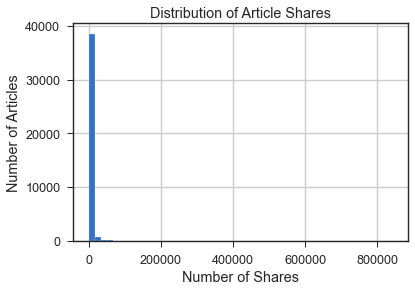

In [10]:
sns.set_style('ticks')

df.hist('shares',bins=50)
plt.title('Distribution of Article Shares')
plt.xlabel('Number of Shares')
plt.ylabel('Number of Articles')

* See if the log of 'shares' normalizes it.

Text(0, 0.5, 'Number of Articles')

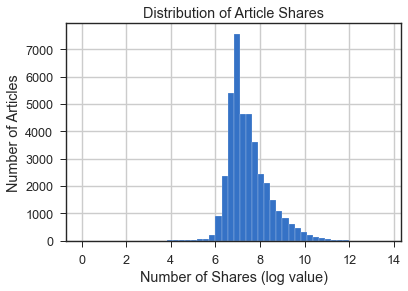

In [11]:
df['log_shares'] = df.shares.apply(lambda x: np.log(x))

df.hist('log_shares', bins=50)
plt.title('Distribution of Article Shares')
plt.xlabel('Number of Shares (log value)')
plt.ylabel('Number of Articles')

* Confirm that we can drop 'timedelta' column along with 'url' column.

Text(0, 0.5, 'Number of Shares (log value)')

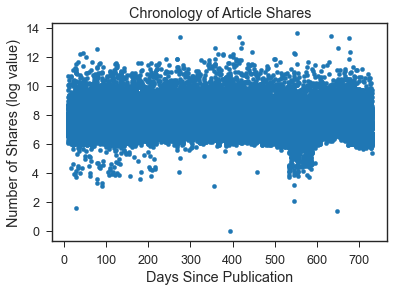

In [12]:
df.plot.scatter('timedelta', 'log_shares', c='tab:blue')
plt.title('Chronology of Article Shares')
plt.xlabel('Days Since Publication')
plt.ylabel('Number of Shares (log value)')

In [13]:
df.drop(columns=['url', 'timedelta'], inplace=True)

## Search for promising continuous variables
* Let's take a quick look at the relationships between potentially important continuous variables.

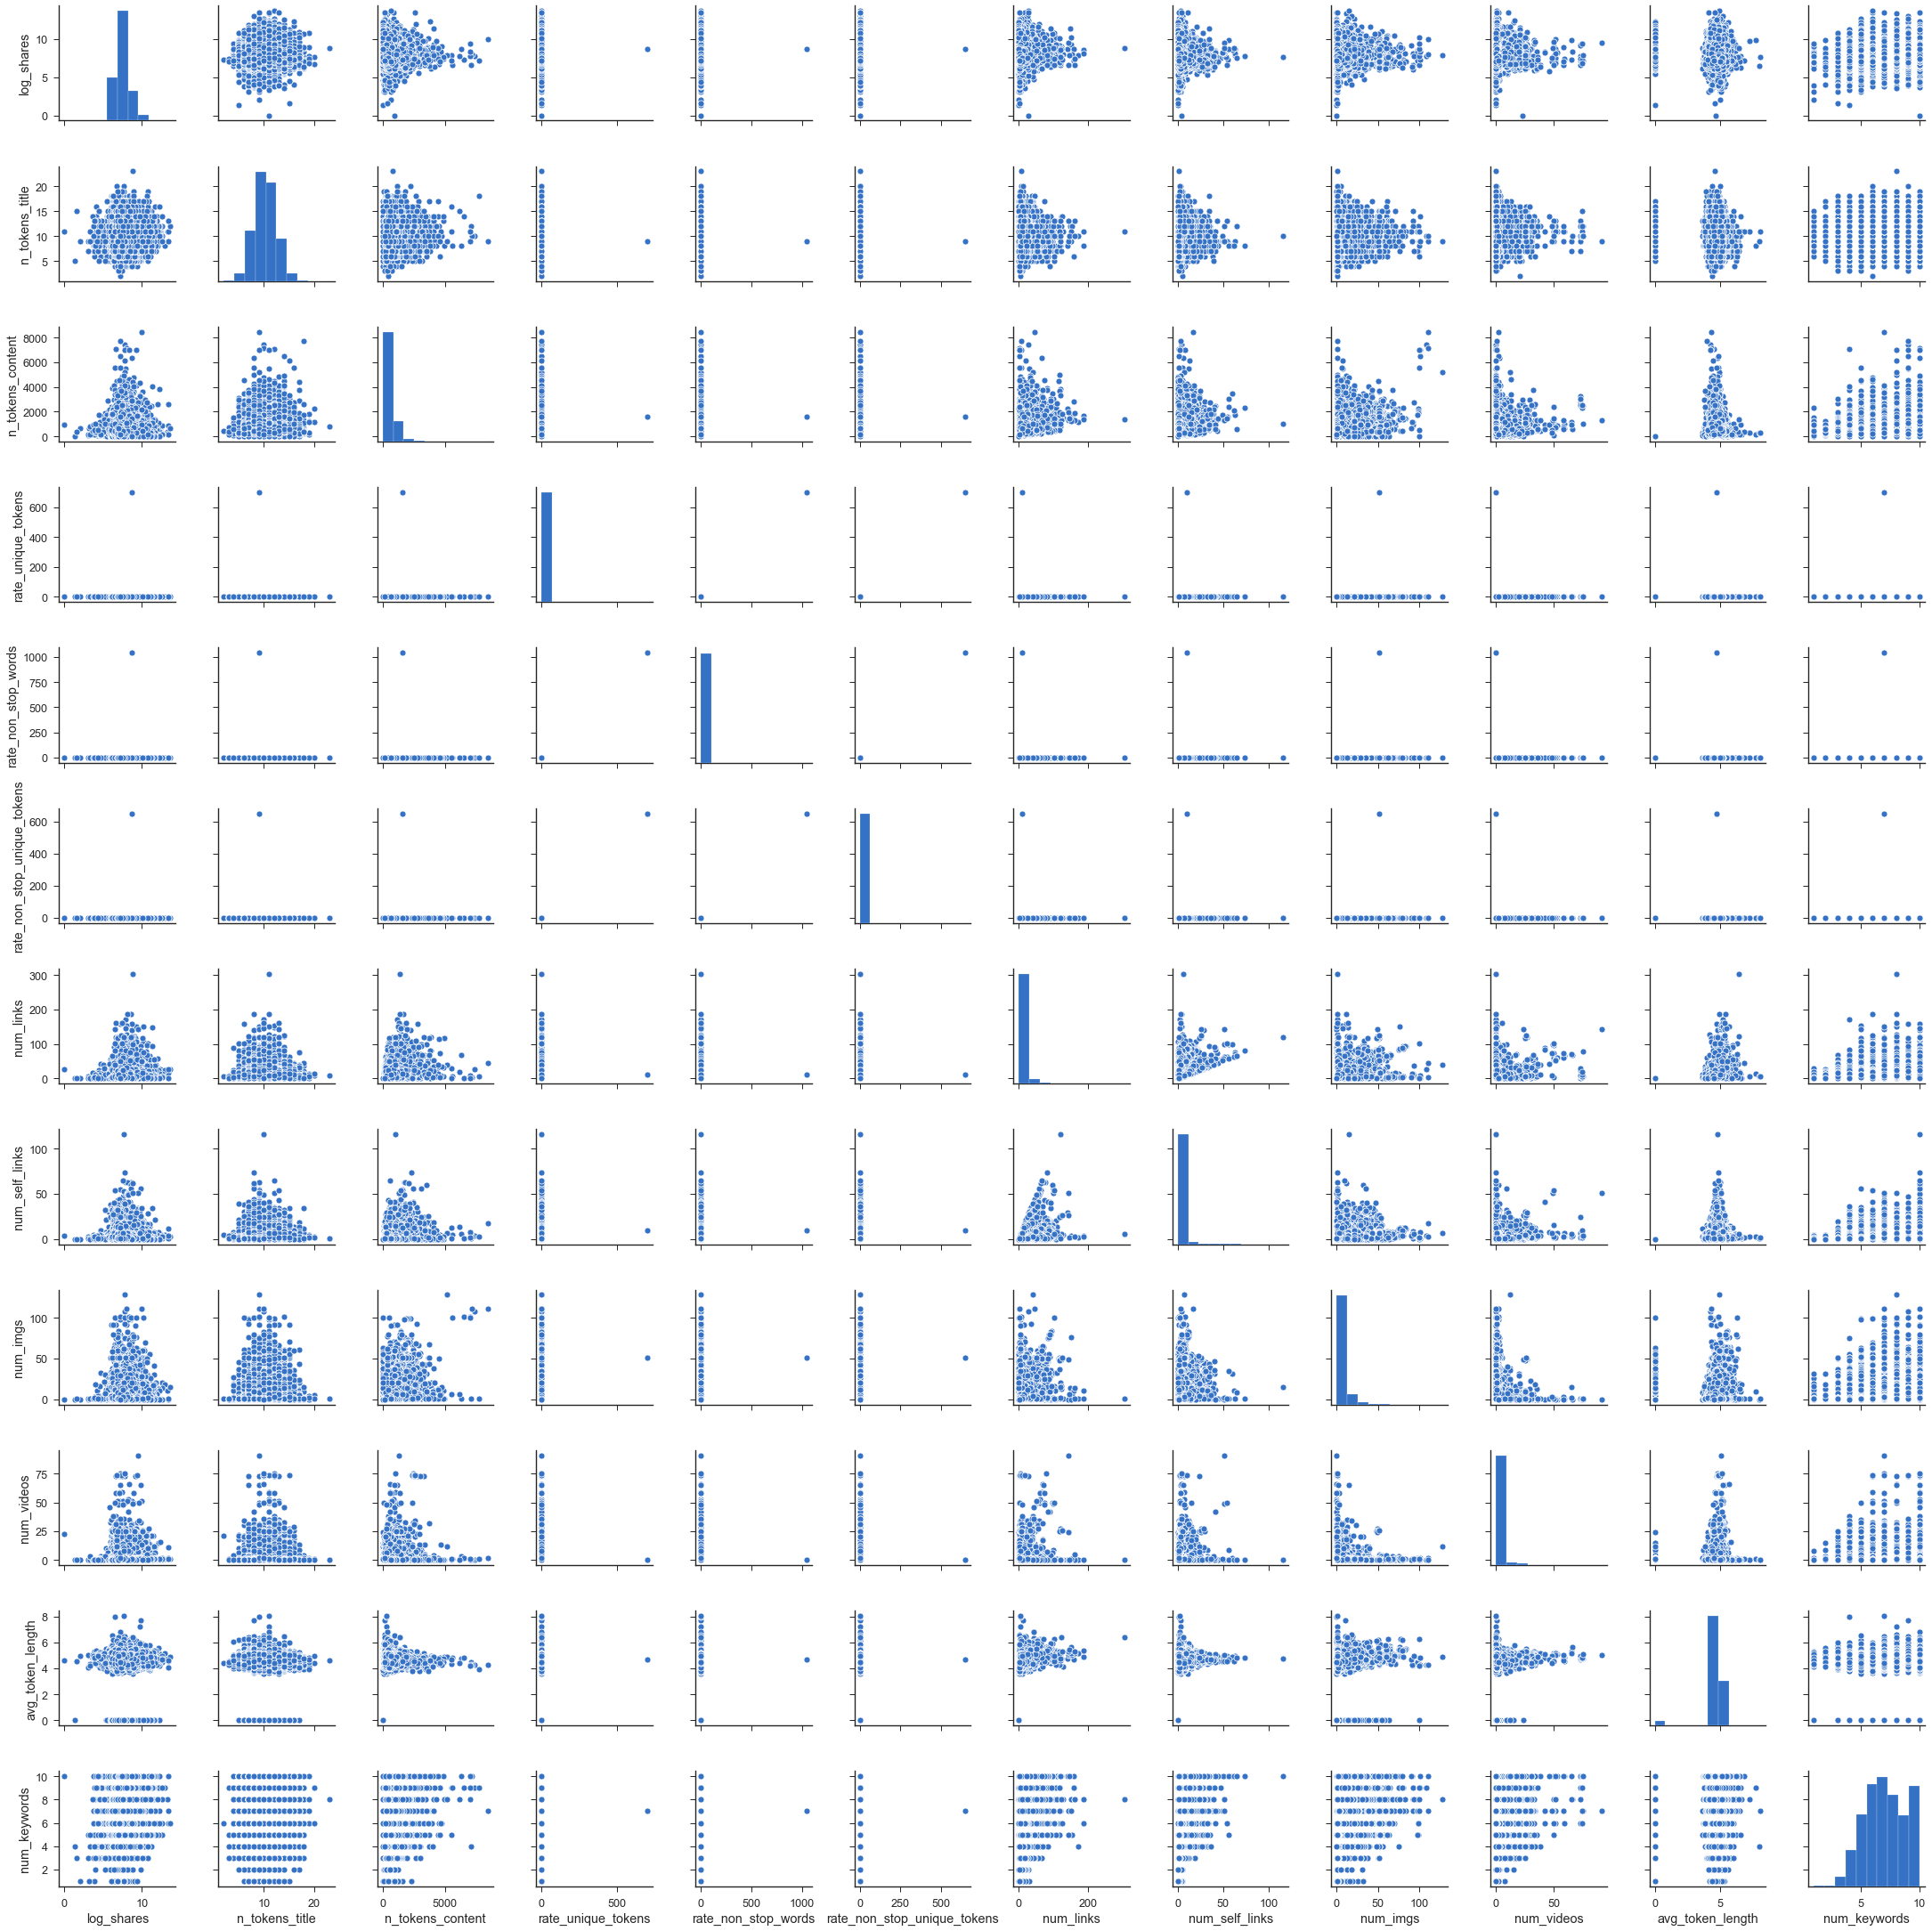

In [14]:
scatter_cols = ['log_shares', 'n_tokens_title', 'n_tokens_content',
                   'rate_unique_tokens', 'rate_non_stop_words',
                   'rate_non_stop_unique_tokens', 'num_links', 'num_self_links',
                   'num_imgs', 'num_videos', 'avg_token_length', 'num_keywords']

sns.pairplot(df[scatter_cols])

* Hm, there don't appear to be any predictive trends between these variables and 'log_shares'. And not much between any other variables either.
* Let's look at our keywords variables.

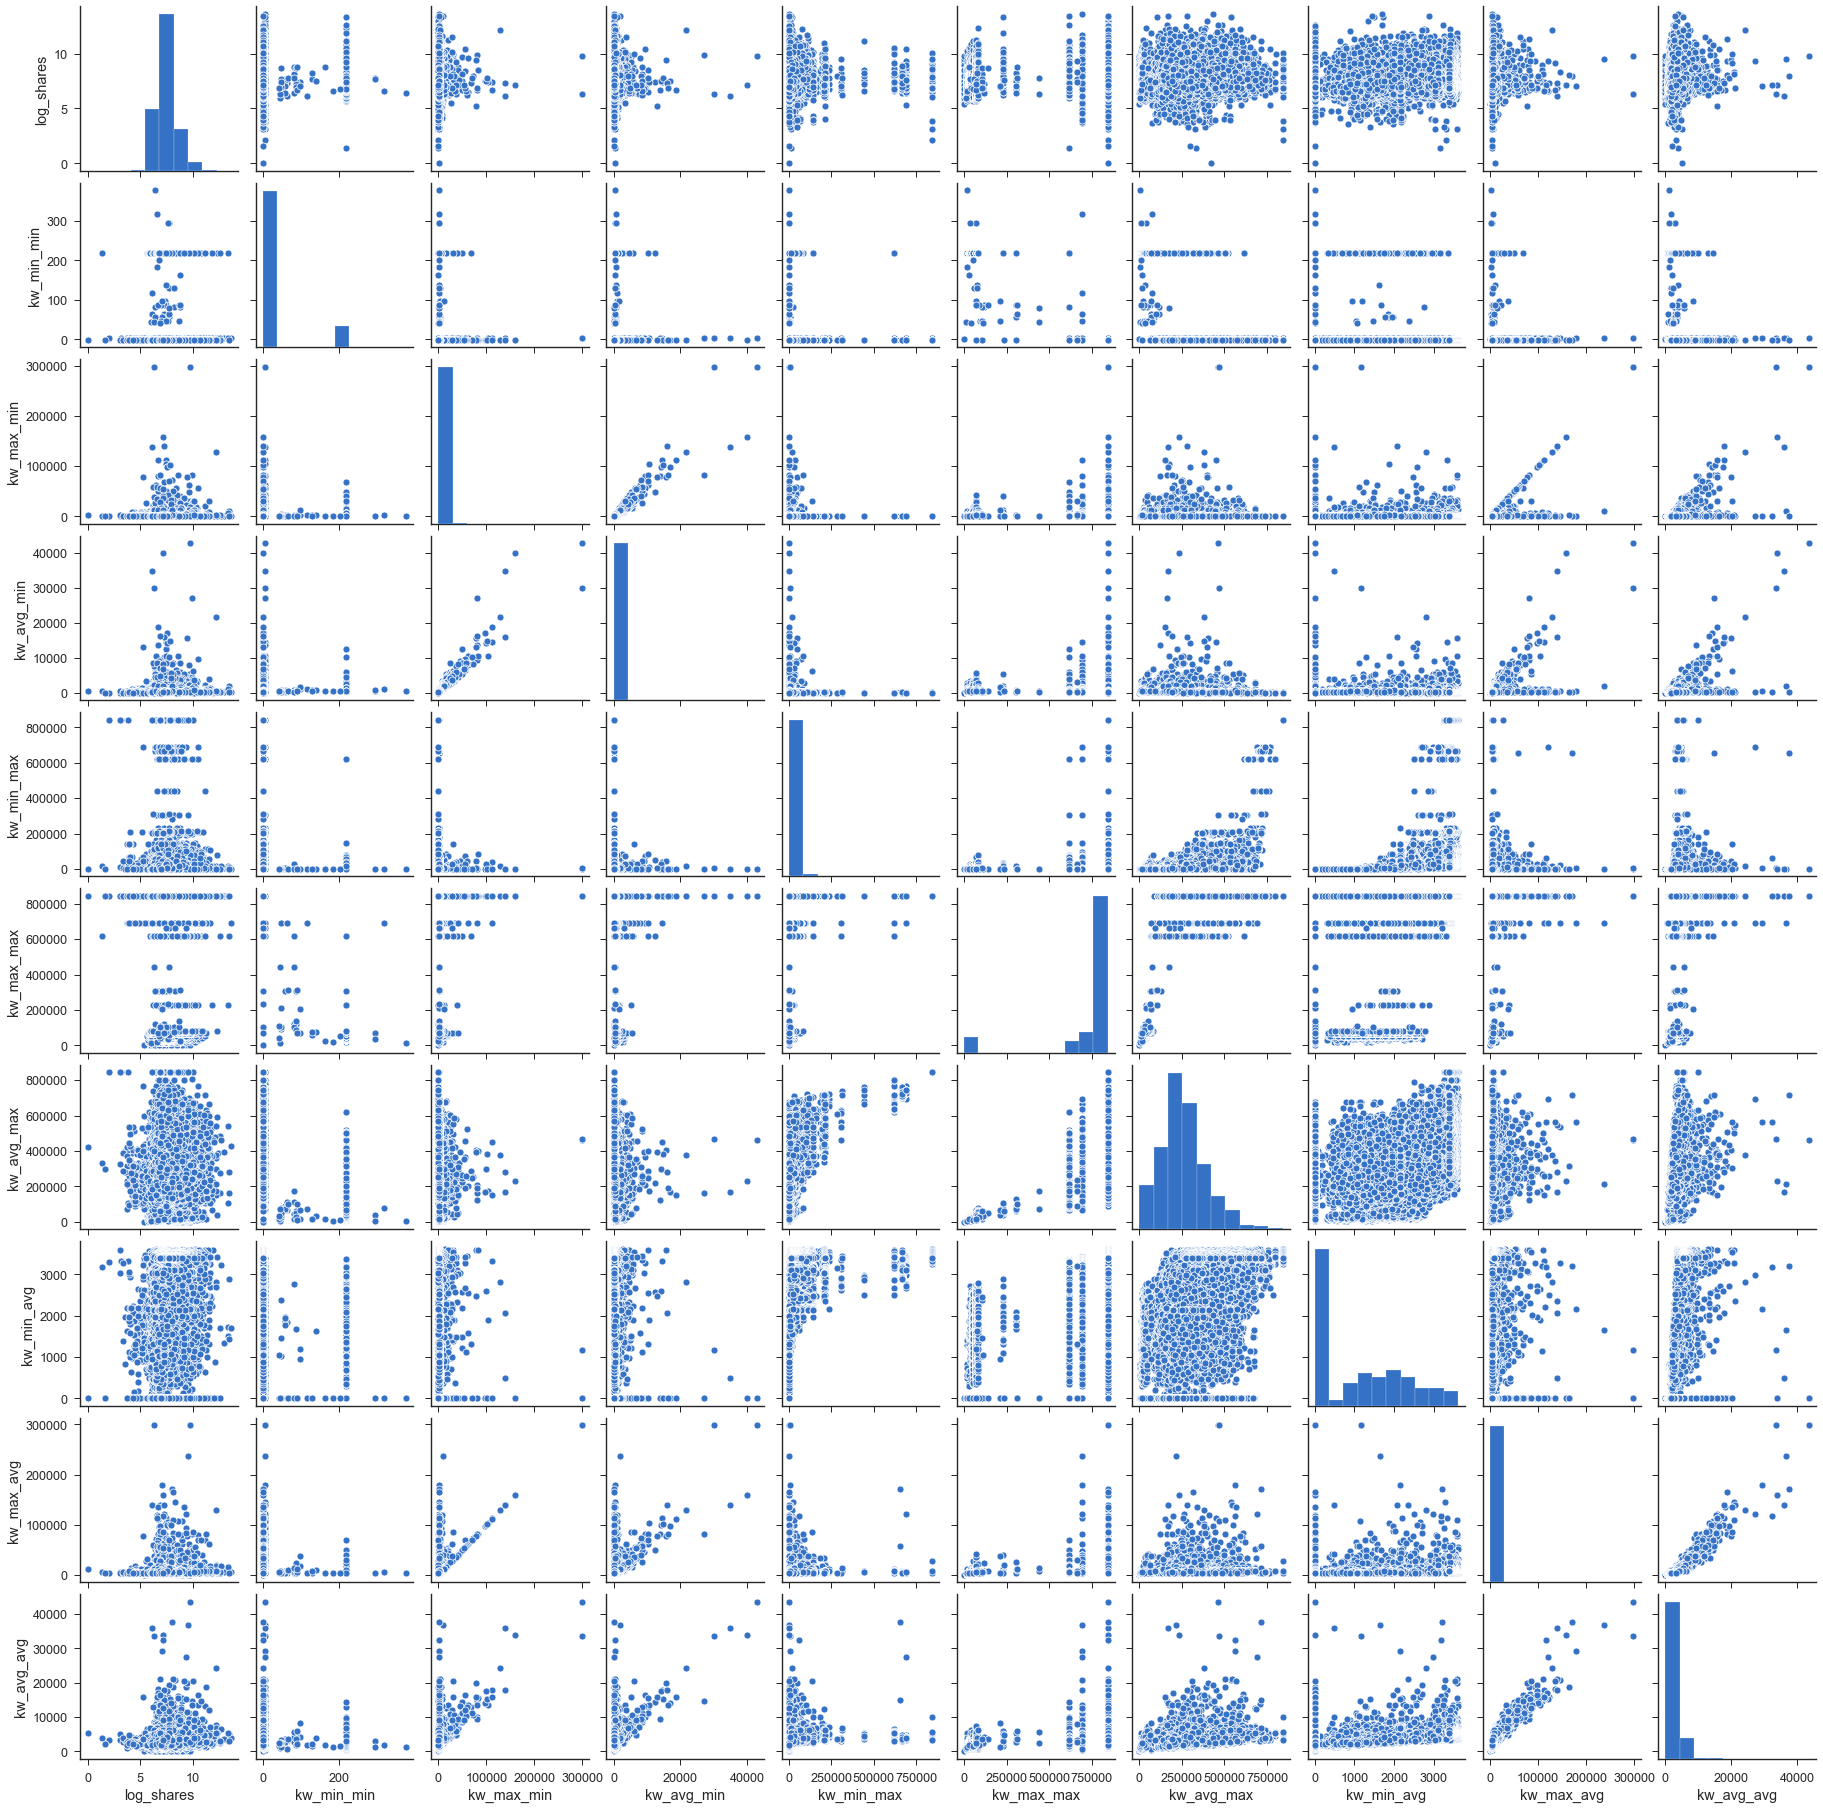

In [15]:
scatter_cols2 = ['log_shares', 'kw_min_min', 'kw_max_min', 'kw_avg_min', 'kw_min_max',
                   'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 'kw_avg_avg']

sns.pairplot(df[scatter_cols2])

* Again, there don't appear to be strong relationships between 'log_shares' and other variables.
* At least now we know we have some cleaning up to do, as well as look into whether we need to drop any highly correlated variables, especially amongst the different keywords variables.

## Look at our categorical variables
* Investigate the effects of genre and day of publication on article shares.
    * Create lists for genre and day columns.
    * Create two dataframes for each category, one to show number of articles and the other to compute the average shares per article.

In [16]:
genre_cols = ['lifestyle', 'entertainment', 'business', 'social_media', 'tech', 'world']
day_cols = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

df_genres = df[genre_cols]
df_days = df[day_cols]
df_genres_avg = df[genre_cols]
df_days_avg = df[day_cols]

In [17]:
# Multiply the dummy columns by the number of shares so we can compute and graph the average shares by genre and day. 
for col in df_genres_avg.columns:
    df_genres_avg[col] = df_genres_avg[col] * df['shares']

for col in df_days_avg.columns:
    df_days_avg[col] = df_days_avg[col] * df['shares']

In [18]:
# Sort both genre dataframes by number of articles to more easily see any trends in popularity.
df_genres_avg = df_genres_avg.reindex(df_genres.sum().sort_values().index, axis=1)
df_genres = df_genres.reindex(df_genres.sum().sort_values().index, axis=1)

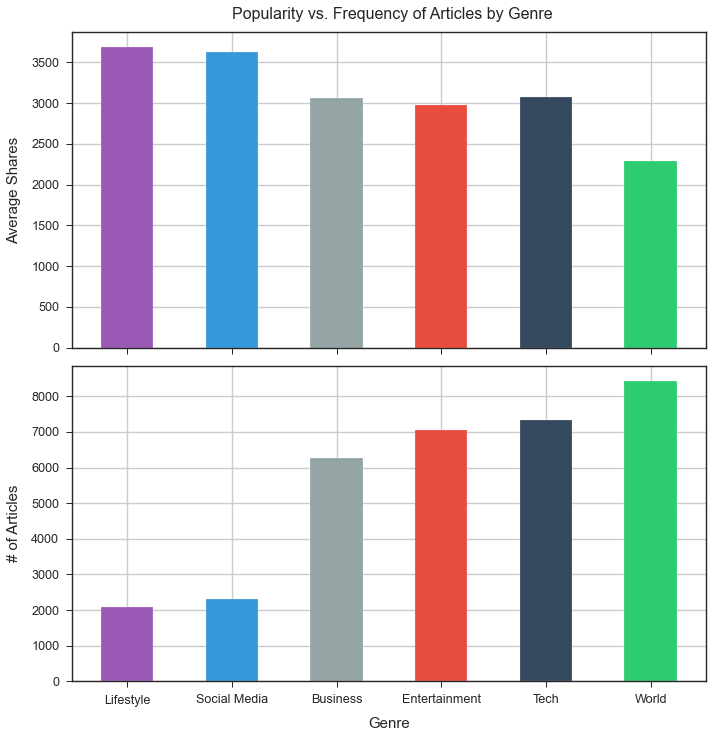

In [19]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,10))
fig.suptitle('Popularity vs. Frequency of Articles by Genre', x=.55, y=1.02, fontsize=16)

genres = [genre.replace('_', ' ').title() for genre in df_genres_avg.columns]
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

ax1.bar(genres, df_genres_avg.sum()/df_genres.sum(), color=colors, width=0.5) 
ax1.set_ylabel('Average Shares', labelpad=10, fontsize=15)
ax1.grid(True)


ax2.bar(genres, df_genres.sum(), color=colors, width=0.5) 
ax2.set_ylabel('# of Articles', labelpad=10, fontsize=15)
ax2.set_xlabel('Genre', labelpad=10, fontsize=15)
ax2.grid(True)


plt.tight_layout()
plt.show() 

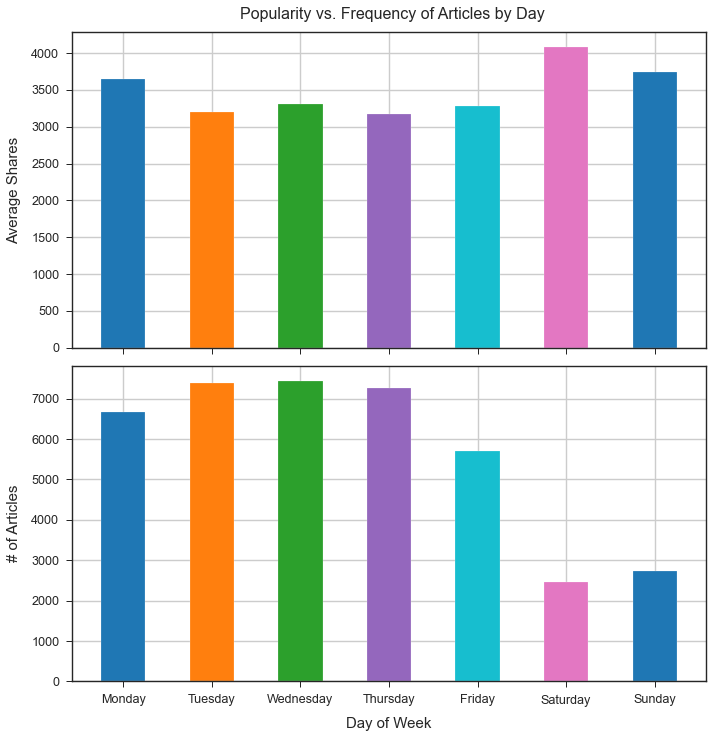

In [20]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10,10))
fig.suptitle('Popularity vs. Frequency of Articles by Day', x=.55, y=1.02, fontsize=16)

days = [day.title() for day in df_days_avg.columns]
colors = ["tab:blue", "tab:orange", "tab:green", "tab:purple", "tab:cyan", "tab:pink"]

ax1.bar(days, df_days_avg.sum()/df_days_avg.astype(bool).sum(axis=0), color=colors, width=0.5) 
ax1.set_ylabel('Average Shares', labelpad=10, fontsize=15)
ax1.grid(True)


ax2.bar(days, df_days.sum(), color=colors, width=0.5) 
# ax2.set_title('Genre Frequency')
ax2.set_ylabel('# of Articles', labelpad=10, fontsize=15)
ax2.set_xlabel('Day of Week', labelpad=10, fontsize=15)
ax2.grid(True)


plt.tight_layout() 
#automatically adjusts plot so that it fits into the figure area.
plt.show() 

* Looks like there may be an interesting inverse relationship between popularity and frequency of both day and genre.
    * Genres with fewer articles seems to get higher shares on average, perhaps pointing to a cult or niche group of readers.
    * Articles published on the weekend seem to have a higher share rate, perhaps due to people having more time to read during those days, using social media more often, or sharing the articles they missed over the weekend during the work week.
* Let's take a more direct look at the 'is_weekend' variable.
* We can then do some statistical tests to see how significant differences in days and genres are.

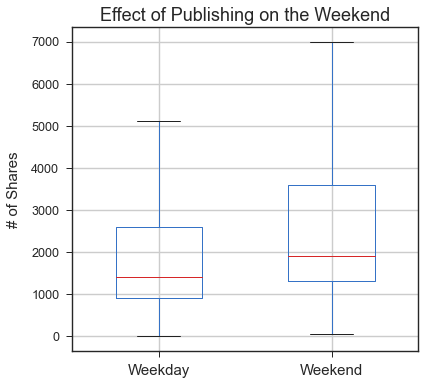

In [21]:
df.boxplot('shares', 'is_weekend', showfliers = False, figsize=(6,6), color={'medians': 'tab:red'}, widths=(0.5, 0.5))
plt.title('Effect of Publishing on the Weekend', fontsize=18)
# get rid of the automatic 'Boxplot grouped by group_by_column_name' title
plt.xlabel('')
plt.xticks([1,2], ['Weekday', 'Weekend'], fontsize=15)
plt.ylabel('# of Shares', fontsize=15, labelpad=10)
plt.suptitle("")

plt.show()

## Statistical tests
* Conduct two-sample t-tests and ANOVAs to find significance of certain variables.

In [22]:
stats.ttest_ind(df['log_shares'][df['is_weekend'] == 0], df['log_shares'][df['is_weekend'] == 1])

Ttest_indResult(statistic=-22.925260177551472, pvalue=1.4723970646529394e-115)

* There is certainly a statistically significant difference between the number of shares of an article published during the week as opposed to one published on Saturday or Sunday.
* Now let's take a series of the shares for each day and genre and conduct ANOVA tests on the days and genres. This allows us to see if two-sample t-tests are necessary.

In [23]:
stats.f_oneway(df['log_shares'][df['monday'] == 1],
               df['log_shares'][df['tuesday'] == 1], 
               df['log_shares'][df['wednesday'] == 1],
               df['log_shares'][df['thursday'] == 1],
               df['log_shares'][df['friday'] == 1],
               df['log_shares'][df['saturday'] == 1],
               df['log_shares'][df['sunday'] == 1])

F_onewayResult(statistic=93.75699445961253, pvalue=1.9606972795804355e-117)

In [24]:
stats.f_oneway(df['log_shares'][df['lifestyle'] == 1],
               df['log_shares'][df['social_media'] == 1], 
               df['log_shares'][df['business'] == 1],
               df['log_shares'][df['entertainment'] == 1],
               df['log_shares'][df['tech'] == 1],
               df['log_shares'][df['world'] == 1])

F_onewayResult(statistic=282.01156079766014, pvalue=1.5869674208057058e-296)

* Since we can see that there are stastically significant differences present, we'll take those day/genre series and make lists for each category. Then we'll run this through a function that will perform two-sample t-tests on every possible combination.

In [25]:
day_shares_list = [df['log_shares'][df['monday'] == 1],
                    df['log_shares'][df['tuesday'] == 1], 
                    df['log_shares'][df['wednesday'] == 1],
                    df['log_shares'][df['thursday'] == 1],
                    df['log_shares'][df['friday'] == 1],
                    df['log_shares'][df['saturday'] == 1],
                    df['log_shares'][df['sunday'] == 1]]

genre_shares_list = [df['log_shares'][df['lifestyle'] == 1],
                       df['log_shares'][df['social_media'] == 1], 
                       df['log_shares'][df['business'] == 1],
                       df['log_shares'][df['entertainment'] == 1],
                       df['log_shares'][df['tech'] == 1],
                       df['log_shares'][df['world'] == 1]]

In [26]:
two_way_tests(day_shares_list)

{(0,
  1): Ttest_indResult(statistic=2.707686425128693, pvalue=0.006783597470638069),
 (0,
  2): Ttest_indResult(statistic=3.359103150972496, pvalue=0.0007840314903441153),
 (0,
  3): Ttest_indResult(statistic=2.380628768814688, pvalue=0.01729648835274575),
 (0,
  4): Ttest_indResult(statistic=-1.6960806783143105, pvalue=0.08989578495244195),
 (0,
  5): Ttest_indResult(statistic=-13.658890813901028, pvalue=4.630609371744755e-42),
 (0,
  6): Ttest_indResult(statistic=-13.182790649830217, pvalue=2.4605788304687935e-39),
 (1,
  2): Ttest_indResult(statistic=0.6856817827866252, pvalue=0.4929245202923791),
 (1,
  3): Ttest_indResult(statistic=-0.3318196185945406, pvalue=0.7400302144402047),
 (1,
  4): Ttest_indResult(statistic=-4.444213039817958, pvalue=8.893906026248587e-06),
 (1,
  5): Ttest_indResult(statistic=-16.308643045668532, pvalue=5.07365273227383e-59),
 (1,
  6): Ttest_indResult(statistic=-15.908492220223934, pvalue=2.653997938081179e-56),
 (2,
  3): Ttest_indResult(statistic=-1.

In [27]:
two_way_tests(genre_shares_list)

{(0,
  1): Ttest_indResult(statistic=-6.401948655647247, pvalue=1.6936962903254976e-10),
 (0,
  2): Ttest_indResult(statistic=8.989798779296944, pvalue=3.0220857066612855e-19),
 (0,
  3): Ttest_indResult(statistic=12.719296054303907, pvalue=9.446259352703864e-37),
 (0,
  4): Ttest_indResult(statistic=1.1631470776571808, pvalue=0.24479922539181842),
 (0,
  5): Ttest_indResult(statistic=19.31374186770843, pvalue=1.0581481488755088e-81),
 (1,
  2): Ttest_indResult(statistic=18.046166979345607, pvalue=1.755666956406562e-71),
 (1,
  3): Ttest_indResult(statistic=21.452881082876278, pvalue=1.0420675936420834e-99),
 (1,
  4): Ttest_indResult(statistic=10.04936286615862, pvalue=1.2077355965363071e-23),
 (1,
  5): Ttest_indResult(statistic=29.42182687926758, pvalue=4.609625037002621e-183),
 (2,
  3): Ttest_indResult(statistic=6.418040532950982, pvalue=1.4271724450214742e-10),
 (2,
  4): Ttest_indResult(statistic=-12.13568083241877, pvalue=1.0206894608856955e-33),
 (2,
  5): Ttest_indResult(stat

## Statistical tests conclusions
* Individual days of the week don't consistently exhibit a statistically significant difference from each other, but the difference between weekdays and weekends **is** statistically significant.
* Other than between 'lifestyle' and 'entertainment', genres **do** exhibit statistically significant differences from each other.

## Cleaning columns and their values
* First, let's drop:
    * unnecessary columns.
    * one dummy column from each category (genres, days of the week, and LDA).
        * *While LDA columns aren't truly categorical, they do exhibit similar tendencies to what makes dropping at least one dummy column necessary.*
    * and columns with unknown or suspicious values.

In [28]:
df.drop(columns=[
                 'shares', 'self_ref_min_shares', 'self_ref_max_shares', # unnecessary columns
                 'monday', 'lifestyle', 'LDA_00', # remove one dummy variable from genres and days of the week
                 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
                 'kw_max_max', 'kw_min_min', 'rate_non_stop_words' # unknown/suspicious values
                                            ], inplace=True)

* See if anything is too correlated, and if so, drop those columns.

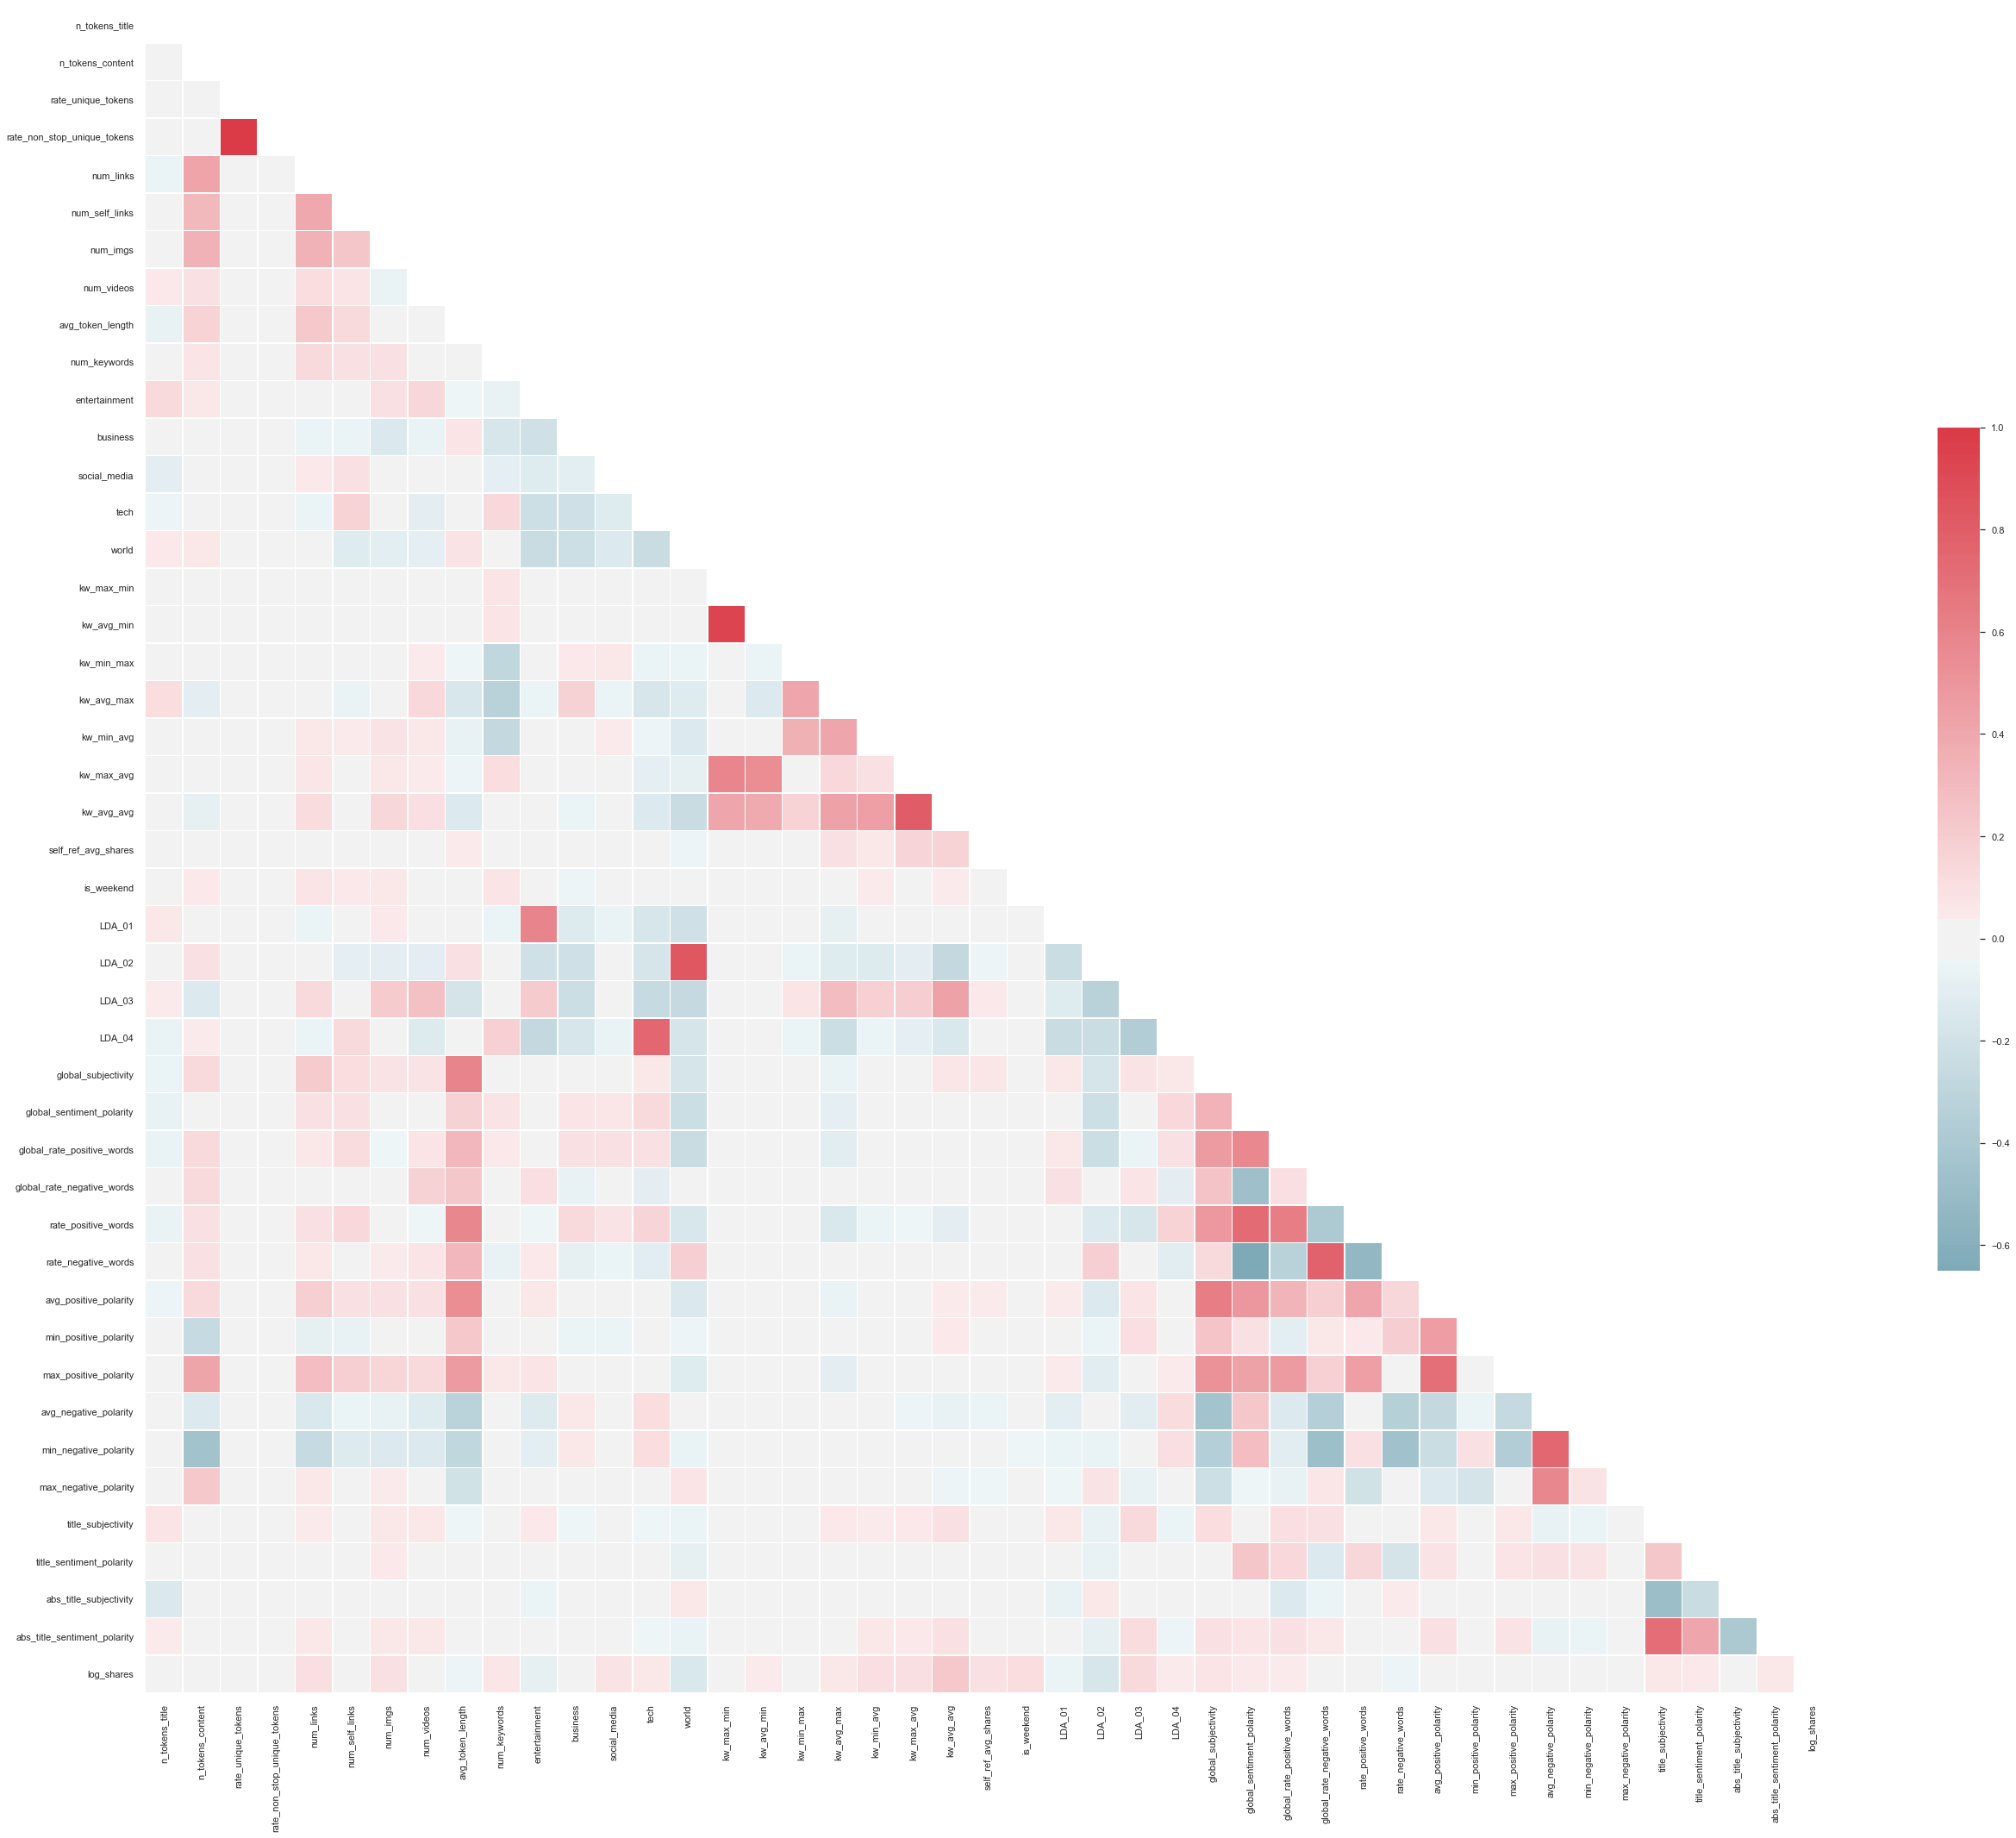

In [29]:
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(44, 36))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

* Not too many

In [30]:
df.drop(columns=['rate_unique_tokens', 'kw_max_min'], inplace=True)

## Early modeling
* Let's have a preliminary look at some modeling numbers before doing any more cleaning.

In [31]:
test_features = list(df.columns)
# remove target variable
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model_01 = ols(formula=f, data=df).fit()
# save r-squared value for later
basic_model_r2 = round(model_01.rsquared, 3)

model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     131.9
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        11:12:21   Log-Likelihood:                -50801.
No. Observations:               39644   AIC:                         1.017e+05
Df Residuals:                   39601   BIC:                         1.021e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        6.9525      0.056    123.241      0.000       6.842       7.063
n_tokens_title                   0.0071      0.002      3.267      0.001       0.003       0.011
n_tokens_content              3.622e-05   1.39e-05      2.613      0.009    9.05e-06    6.34e-05
rate_non_stop_unique_tokens      0.0023      0.001      1.687      0.092      -0.000       0.005
num_links                        0.0043      0.001      8.535      0.000       0.003       0.005
num_self_links                  -0.0078      0.001     -5.913      0.000      -0.010      -0.005
num_imgs                         0.0030      0.001      4.763      0.000       0.002       0.004
num_videos                       0.0030      0.001      2.580      0.010       0.001       0.005
avg_token_length                -0.0845      0.017     -4.875      0.000      -0.118      -0.051
num_keywords                     0.0079      0.003      2.904      0.004       0.003       0.013
entertainment                   -0.1939      0.018    -11.000      0.000      -0.228      -0.159
business                        -0.1134      0.024     -4.669      0.000      -0.161      -0.066
social_media                     0.1861      0.024      7.695      0.000       0.139       0.234
tech                             0.1570      0.020      7.744      0.000       0.117       0.197
world                           -0.0161      0.024     -0.670      0.503      -0.063       0.031
kw_avg_min                   -2.359e-05   8.81e-06     -2.679      0.007   -4.09e-05   -6.33e-06
kw_min_max                   -2.202e-07   8.66e-08     -2.543      0.011    -3.9e-07   -5.05e-08
kw_avg_max                   -5.316e-07   4.84e-08    -10.987      0.000   -6.26e-07   -4.37e-07
kw_min_avg                   -4.437e-05   5.64e-06     -7.873      0.000   -5.54e-05   -3.33e-05
kw_max_avg                   -3.901e-05   1.79e-06    -21.822      0.000   -4.25e-05   -3.55e-05
kw_avg_avg                       0.0003   1.04e-05     30.587      0.000       0.000       0.000
self_ref_avg_shares           1.952e-06   1.85e-07     10.540      0.000    1.59e-06    2.32e-06
is_weekend                       0.2581      0.013     19.646      0.000       0.232       0.284
LDA_01                          -0.3102      0.038     -8.173      0.000      -0.385      -0.236
LDA_02                          -0.4514      0.038    -11.931      0.000      -0.526      -0.377
LDA_03                          -0.2518      0.035     -7.224      0.000      -0.320      -0.184
LDA_04                          -0.2496      0.034     -7.290      0.000      -0.317      -0.182
global_subjectivity              0.4109      0.064      6.381      0.000       0.285       0.537
global_sentiment_polarity       -0.1273      0.126     -1.008      0.313    

* R<sup>2</sup> value is very low (0.123), so let's see if we can bring it up a bit.

    
## More cleaning
* Some of our coefficients are on a wildly different scale, so let's see if a log transformation helps with those.
* Also, a closer look at some of the columns shows some suspicious values of 0 and 1 for the rate of certain tokens and token types.
* Finally, some values are below 1 for columns that measure in article shares, even though the minimum value for shares is 1.
    * Reassign those 0s and 1s to each column's median value.
    * Reassign to 1 any values less than 1 in columns measuring in shares.
    * Transform data measured in number of shares to their logarithmic value.

In [32]:
less_set_to_one_cols = ['kw_avg_min', 'kw_min_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
                        'kw_avg_avg', 'self_ref_avg_shares', 'n_tokens_content']

zero_to_median_cols = ['avg_token_length', 'n_tokens_content', 'global_subjectivity', 'global_rate_positive_words',
                       'rate_positive_words', 'rate_negative_words', 'avg_positive_polarity', 'avg_negative_polarity']

one_to_median_cols = ['rate_non_stop_unique_tokens', 'rate_positive_words', 'rate_negative_words', 
                      'avg_positive_polarity']

In [33]:
for column in less_set_to_one_cols:
    less_set_to_one(df, column)  
    
for column in zero_to_median_cols:
    zero_to_median(df, column)
    
for column in one_to_median_cols:
    one_to_median(df, column)

great_set_to_one(df, 'rate_non_stop_unique_tokens')
    
neg_one_to_median(df, 'avg_negative_polarity')

for column in less_set_to_one_cols:
    log_col(df, column)

In [34]:
test_features = list(df.columns)
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model_02 = ols(formula=f, data=df).fit()

scaled_coef_model_r2 = round(model_02.rsquared, 3)

model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     126.6
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        11:12:22   Log-Likelihood:                -50955.
No. Observations:               39644   AIC:                         1.020e+05
Df Residuals:                   39602   BIC:                         1.024e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        4.7675      3.131      1.523      0.128      -1.369      10.904
n_tokens_title                   0.0069      0.002      3.160      0.002       0.003       0.011
rate_non_stop_unique_tokens     -0.1976      0.043     -4.614      0.000      -0.281      -0.114
num_links                        0.0059      0.001     11.641      0.000       0.005       0.007
num_self_links                  -0.0150      0.001    -10.858      0.000      -0.018      -0.012
num_imgs                         0.0029      0.001      4.439      0.000       0.002       0.004
num_videos                       0.0017      0.001      1.423      0.155      -0.001       0.004
avg_token_length                -0.0664      0.018     -3.787      0.000      -0.101      -0.032
num_keywords                     0.0097      0.003      3.454      0.001       0.004       0.015
entertainment                   -0.2798      0.017    -16.249      0.000      -0.314      -0.246
business                        -0.1619      0.024     -6.689      0.000      -0.209      -0.114
social_media                     0.1393      0.024      5.770      0.000       0.092       0.187
tech                             0.1142      0.020      5.630      0.000       0.074       0.154
world                           -0.0771      0.024     -3.204      0.001      -0.124      -0.030
is_weekend                       0.2646      0.013     20.068      0.000       0.239       0.290
LDA_01                          -0.2637      0.038     -6.911      0.000      -0.339      -0.189
LDA_02                          -0.4729      0.038    -12.460      0.000      -0.547      -0.398
LDA_03                          -0.1730      0.035     -4.983      0.000      -0.241      -0.105
LDA_04                          -0.2941      0.034     -8.563      0.000      -0.361      -0.227
global_subjectivity              0.5109      0.063      8.105      0.000       0.387       0.634
global_sentiment_polarity       -0.3340      0.115     -2.894      0.004      -0.560      -0.108
global_rate_positive_words      -0.7344      0.549     -1.337      0.181      -1.811       0.342
global_rate_negative_words       1.0936      1.044      1.047      0.295      -0.953       3.140
rate_positive_words              1.1236      3.343      0.336      0.737      -5.430       7.677
rate_negative_words              0.8057      3.385      0.238      0.812      -5.829       7.440
avg_positive_polarity            0.0663      0.096      0.688      0.491      -0.123       0.255
min_positive_polarity           -0.2418      0.081     -2.969      0.003      -0.401      -0.082
max_positive_polarity            0.0094      0.033      0.287      0.774      -0.055       0.074
avg_negative_polarity           -1.2078      0.793     -1.523      0.128    

* Hm, a lower R<sup>2</sup>, but the scale of the coefficients looks way better.
* Let's replace some extreme values.
* Then let's categorize the image and video columns, since the number itself doesn't seem to hold much value.

In [35]:
extreme_cols = find_extremes(df)
# Remove target variable, so we don't replace any values.
extreme_cols.remove('log_shares')
df[extreme_cols].describe()

,n_tokens_title,rate_non_stop_unique_tokens,num_links,num_self_links,num_imgs,num_videos,avg_token_length,social_media,global_subjectivity,global_subjectivity,...,title_sentiment_polarity,log_shares,log_kw_avg_min,log_kw_avg_min,log_kw_avg_max,log_kw_max_avg,log_kw_max_avg,log_kw_avg_avg,log_kw_avg_avg,log_n_tokens_content
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,0.672805,10.883690,3.293638,4.544143,1.249874,4.687183,0.058597,0.456913,0.456913,...,0.071425,7.474855,5.285117,5.285117,12.241858,8.482530,8.482530,7.975971,7.975971,5.887062
std,2.114037,0.154042,11.332017,3.855141,8.309434,4.107855,0.279009,0.234871,0.086970,0.086970,...,0.265450,0.930486,1.159682,1.159682,0.943071,0.582098,0.582098,0.489534,0.489534,1.256215
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.600000,0.000000,0.022222,0.022222,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.502244,0.000000,0.404489,0.404489,...,0.000000,6.852243,4.954065,4.954065,12.060161,8.178106,8.178106,7.775884,7.775884,5.505332
50%,10.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664084,0.000000,0.453458,0.453458,...,0.000000,7.244228,5.461711,5.461711,12.407266,8.379238,8.379238,7.962093,7.962093,6.013715
75%,12.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,0.000000,0.508333,0.508333,...,0.150000,7.937375,5.877736,5.877736,12.709813,8.702835,8.702835,8.188753,8.188753,6.573680
max,23.000000,1.000000,304.000000,116.000000,128.000000,91.000000,8.041534,1.000000,1.000000,1.000000,...,1.000000,13.645078,10.664944,10.664944,13.645078,12.606190,12.606190,10.682070,10.682070,9.044758


In [36]:
rein_extremes(df, extreme_cols)
df.describe()

,n_tokens_title,rate_non_stop_unique_tokens,num_links,num_self_links,num_imgs,num_videos,avg_token_length,num_keywords,entertainment,business,...,abs_title_sentiment_polarity,log_shares,log_kw_avg_min,log_kw_min_max,log_kw_avg_max,log_kw_min_avg,log_kw_max_avg,log_kw_avg_avg,log_self_ref_avg_shares,log_n_tokens_content
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398565,0.674492,10.671710,3.193118,4.369646,1.109187,4.686590,7.223767,0.178009,0.157855,...,0.156064,7.473784,5.308137,5.045032,12.259005,4.258814,8.491980,7.988524,6.667274,5.912747
std,2.113181,0.146803,9.909757,3.137274,7.214085,3.052417,0.275593,1.909130,0.382525,0.364610,...,0.226294,0.922311,1.058561,4.520923,0.785279,3.726459,0.428693,0.337462,3.280200,1.138918
min,2.000000,0.056637,0.000000,0.000000,0.000000,0.000000,3.600000,1.000000,0.000000,0.000000,...,0.000000,3.752911,0.943081,0.000000,8.469573,0.000000,6.711233,6.603144,0.000000,0.862203
25%,9.000000,0.625739,4.000000,1.000000,1.000000,0.000000,4.502244,6.000000,0.000000,0.000000,...,0.000000,6.852243,4.954065,0.000000,12.060161,0.000000,8.178106,7.775884,6.888764,5.505332
50%,10.000000,0.690476,8.000000,3.000000,1.000000,0.000000,4.664084,7.000000,0.000000,0.000000,...,0.000000,7.244228,5.461711,7.244228,12.407266,6.931116,8.379238,7.962093,7.696213,6.013715
75%,12.000000,0.754630,14.000000,4.000000,4.000000,1.000000,4.854839,9.000000,0.000000,0.000000,...,0.250000,7.937375,5.877736,8.974618,12.709813,7.628897,8.702835,8.188753,8.556414,6.573680
max,18.854896,1.000000,56.211759,18.714203,37.781877,17.681294,5.803220,10.000000,1.000000,1.000000,...,1.000000,11.196799,9.658672,13.645078,13.645078,8.192305,10.275553,9.372541,13.645078,9.044758


* Create and take a quick look at 'has_img' and 'has_video' variables to see if we should keep those in as statistically significant.

In [37]:
df['has_img'] = np.where(df.num_imgs > 0, 1, 0)
df['has_video'] = np.where(df.num_videos > 0, 1, 0)

In [38]:
print(stats.ttest_ind(df['log_shares'][df['has_img'] == 0], df['log_shares'][df['has_img'] == 1]))
print(stats.ttest_ind(df['log_shares'][df['has_video'] == 0], df['log_shares'][df['has_video'] == 1]))

Ttest_indResult(statistic=7.793541345364229, pvalue=6.673958025673746e-15)
Ttest_indResult(statistic=-14.026902961932644, pvalue=1.364452568332951e-44)


In [39]:
test_features = list(df.columns)
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model_03 = ols(formula=f, data=df).fit()

no_extremes_model_r2 = round(model_03.rsquared, 3)

model_03.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     142.2
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        11:12:23   Log-Likelihood:                -50200.
No. Observations:               39644   AIC:                         1.005e+05
Df Residuals:                   39600   BIC:                         1.009e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.5499      3.179      0.488      0.626      -4.681       7.781
n_tokens_title                   0.0049      0.002      2.300      0.021       0.001       0.009
rate_non_stop_unique_tokens     -0.2013      0.044     -4.567      0.000      -0.288      -0.115
num_links                        0.0061      0.001     10.452      0.000       0.005       0.007
num_self_links                  -0.0178      0.002    -10.267      0.000      -0.021      -0.014
num_imgs                         0.0036      0.001      4.579      0.000       0.002       0.005
num_videos                      -0.0035      0.002     -1.989      0.047      -0.007   -5.18e-05
avg_token_length                -0.0581      0.018     -3.307      0.001      -0.093      -0.024
num_keywords                     0.0014      0.003      0.512      0.609      -0.004       0.007
entertainment                   -0.1976      0.017    -11.409      0.000      -0.232      -0.164
business                        -0.0868      0.024     -3.632      0.000      -0.134      -0.040
social_media                     0.1799      0.024      7.559      0.000       0.133       0.227
tech                             0.1640      0.020      8.183      0.000       0.125       0.203
world                           -0.0054      0.024     -0.228      0.820      -0.052       0.041
is_weekend                       0.2637      0.013     20.375      0.000       0.238       0.289
LDA_01                          -0.2976      0.038     -7.920      0.000      -0.371      -0.224
LDA_02                          -0.3887      0.037    -10.389      0.000      -0.462      -0.315
LDA_03                          -0.2839      0.035     -8.226      0.000      -0.352      -0.216
LDA_04                          -0.2441      0.034     -7.228      0.000      -0.310      -0.178
global_subjectivity              0.4391      0.062      7.036      0.000       0.317       0.561
global_sentiment_polarity       -0.3178      0.114     -2.781      0.005      -0.542      -0.094
global_rate_positive_words      -0.8679      0.567     -1.532      0.126      -1.979       0.243
global_rate_negative_words       1.4499      1.125      1.289      0.197      -0.754       3.654
rate_positive_words              1.5658      3.393      0.461      0.644      -5.085       8.216
rate_negative_words              1.2430      3.437      0.362      0.718      -5.494       7.980
avg_positive_polarity            0.0867      0.094      0.920      0.358      -0.098       0.271
min_positive_polarity           -0.3010      0.090     -3.357      0.001      -0.477      -0.125
max_positive_polarity           -0.0050      0.032     -0.154      0.878      -0.068       0.058
avg_negative_polarity           -0.3927      0.805     -0.488      0.626    

* The best R<sup>2</sup> yet! Reining in the extreme values gave us a 9% bump.
* Let's try to simplify our model by dropping any variables with high p-values.

In [40]:
df_test = df.drop(columns=['num_videos', 'num_keywords', 'world', 'global_rate_positive_words',
                           'global_rate_negative_words', 'rate_negative_words', 'min_negative_polarity',
                           'max_negative_polarity', 'max_positive_polarity', 'avg_negative_polarity', 
                           'avg_positive_polarity', 'abs_title_sentiment_polarity', 'log_kw_min_max',
                           'log_n_tokens_content'])

In [41]:
test_features = list(df_test.columns)
test_features.remove('log_shares')

col_list = '+'.join(test_features)
f = 'log_shares~' + col_list
model_04 = ols(formula=f, data=df).fit()

p_removal_model_r2 = round(model_04.rsquared, 3)

model_04.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     203.2
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        11:12:23   Log-Likelihood:                -50208.
No. Observations:               39644   AIC:                         1.005e+05
Df Residuals:                   39613   BIC:                         1.007e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       2.9155      0.177     16.431      0.000       2.568       3.263
n_tokens_title                  0.0049      0.002      2.286      0.022       0.001       0.009
rate_non_stop_unique_tokens    -0.2334      0.036     -6.501      0.000      -0.304      -0.163
num_links                       0.0059      0.001     11.050      0.000       0.005       0.007
num_self_links                 -0.0181      0.002    -10.505      0.000      -0.021      -0.015
num_imgs                        0.0036      0.001      4.791      0.000       0.002       0.005
avg_token_length               -0.0587      0.017     -3.418      0.001      -0.092      -0.025
entertainment                  -0.2003      0.016    -12.377      0.000      -0.232      -0.169
business                       -0.0885      0.022     -4.038      0.000      -0.131      -0.046
social_media                    0.1781      0.022      8.214      0.000       0.136       0.221
tech                            0.1640      0.018      9.186      0.000       0.129       0.199
is_weekend                      0.2643      0.013     20.483      0.000       0.239       0.290
LDA_01                         -0.2919      0.037     -7.867      0.000      -0.365      -0.219
LDA_02                         -0.3948      0.033    -11.811      0.000      -0.460      -0.329
LDA_03                         -0.2828      0.033     -8.474      0.000      -0.348      -0.217
LDA_04                         -0.2426      0.034     -7.219      0.000      -0.308      -0.177
global_subjectivity             0.4767      0.057      8.410      0.000       0.366       0.588
global_sentiment_polarity      -0.3448      0.074     -4.661      0.000      -0.490      -0.200
rate_positive_words             0.1774      0.051      3.461      0.001       0.077       0.278
min_positive_polarity          -0.2567      0.078     -3.281      0.001      -0.410      -0.103
title_subjectivity              0.0638      0.016      4.037      0.000       0.033       0.095
title_sentiment_polarity        0.0824      0.018      4.706      0.000       0.048       0.117
abs_title_subjectivity          0.1276      0.027      4.743      0.000       0.075       0.180
log_kw_avg_min                  0.0139      0.005      2.944      0.003       0.005       0.023
log_kw_avg_max                 -0.1173      0.008    -15.284      0.000      -0.132      -0.102
log_kw_min_avg                 -0.0217      0.002    -14.151      0.000      -0.025      -0.019
log_kw_max_avg                 -0.1486      0.022     -6.844      0.000      -0.191      -0.106
log_kw_avg_avg                  0.9173      0.035     26.097      0.000       0.848       0.986
log_self_ref_avg_shares         0.0274      0.002     17.611      0.000       0.024       0.030
has_img    

* A very slight drop in our R<sup>2</sup>, but fewer variables will help us in the long run.

# Train/test split
## Finalizing features
* Let's move forward with these features and see if we can create any meaningful interactions.

In [42]:
features = df_test.copy()

In [43]:
features.columns

Index(['n_tokens_title', 'rate_non_stop_unique_tokens', 'num_links',
       'num_self_links', 'num_imgs', 'avg_token_length', 'entertainment',
       'business', 'social_media', 'tech', 'is_weekend', 'LDA_01', 'LDA_02',
       'LDA_03', 'LDA_04', 'global_subjectivity', 'global_sentiment_polarity',
       'rate_positive_words', 'min_positive_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity', 'log_shares',
       'log_kw_avg_min', 'log_kw_avg_max', 'log_kw_min_avg', 'log_kw_max_avg',
       'log_kw_avg_avg', 'log_self_ref_avg_shares', 'has_img', 'has_video'],
      dtype='object')

In [44]:
target = features['log_shares']
features_only = features.drop(columns='log_shares')
X_train, X_test, y_train, y_test = train_test_split(features_only, target, random_state=42, test_size=0.2)

## Interactions
### Load interactions pickle

In [45]:
with open('data/final_train_interactions_list.pickle', 'rb') as file:
    interactions = pickle.load(file)

In [46]:
len(interactions)

202

### Maximize R<sup>2</sup>
* We won't use all the interactions in our final model, but let's try it here, so we can see how high our R<sup>2</sup> value goes.

In [47]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

# create a throwaway dataframe for our r^2 investigation
max_r_squared = X_train.copy()

y = y_train.copy()

# create new interaction columns
for i in interactions:
    max_r_squared[i[0]+'_'+i[1]] = max_r_squared[i[0]] * max_r_squared[i[1]]

max_r2_model = np.mean(cross_val_score(regression, max_r_squared, y, scoring='r2', cv=crossvalidation))

max_r2_model

0.1521413595290621

In [48]:
# add on 'log_shares' column so we can model it
max_r2_target = pd.concat([y, max_r_squared], axis=1)

In [49]:
f_list = list(max_r2_target.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model_05 = ols(formula=f, data=max_r2_target).fit()

full_interactions_model_r2 = round(model_05.rsquared, 3)

model_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     27.09
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        11:12:28   Log-Likelihood:                -39563.
No. Observations:               31715   AIC:                         7.959e+04
Df Residuals:                   31482   BIC:                         8.154e+04
Df Model:                         232                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -8.1429      2.870     -2.837      0.005     -13.769      -2.517
n_tokens_title                                      -0.0875      0.046     -1.899      0.058      -0.178       0.003
rate_non_stop_unique_tokens                          1.8910      0.947      1.997      0.046       0.035       3.747
num_links                                           -0.0014      0.014     -0.101      0.920      -0.029       0.026
num_self_links                                       0.0509      0.063      0.813      0.416      -0.072       0.173
num_imgs                                            -0.0079      0.026     -0.308      0.758      -0.058       0.042
avg_token_length                                     0.7028      0.334      2.105      0.035       0.048       1.357
entertainment                                       -0.7676      0.496     -1.549      0.121      -1.739       0.204
business                                            -1.1827      0.589     -2.008      0.045      -2.337      -0.028
social_media                                         0.9817      0.247      3.978      0.000       0.498       1.465
tech                                                 0.5341      0.393      1.359      0.174      -0.236       1.304
is_weekend                                           1.5825      0.488      3.244      0.001       0.626       2.538
LDA_01                                              -0.6603      0.689     -0.959      0.338      -2.010       0.690
LDA_02                                               3.8817      0.874      4.440      0.000       2.168       5.595
LDA_03                                              -0.6923      0.590     -1.174      0.240      -1.848       0.464
LDA_04                                              -0.5176      0.624     -0.830      0.407      -1.740       0.705
global_subjectivity                                  0.9599      1.202      0.798      0.425      -1.397       3.317
global_sentiment_polarity                           -0.3873      1.402     -0.276      0.782      -3.136       2.361
rate_positive_words                                 -0.5551      0.417     -1.332      0.183      -1.372       0.262
min_positive_polarity                               -0.8252      1.415     -0.583      0.560      -3.598       1.948
title_subjectivity                                  -0.1055      0.319     -0.331      0.741      -0.730       0.519
title_sentiment_polarity                             0.1190      0.364      0.327      0.744      -0.595       0.833
abs_title_subjectivity                              -0.3090      0.238     -1.299      0.194      -0.775       0.157
log_kw_avg_min                           

* R-squared value has gone from 0.123 to 0.166, or a 35% increase!

### Use only top interactions
* Unfortunately, the number of features is more than the square root (178) of our sample size. In honor of the curse of dimensionality, let's simplify and go for the top 100.

In [50]:
np.sqrt(len(X_train))

178.08705736240353

In [51]:
top_100 = sorted(interactions, key=lambda inter: inter[2], reverse=True)[:100]
top_100[:10]

[('log_kw_min_avg', 'log_kw_avg_avg', 0.133),
 ('avg_token_length', 'LDA_02', 0.132),
 ('global_subjectivity', 'social_media', 0.132),
 ('min_positive_polarity', 'social_media', 0.132),
 ('n_tokens_title', 'num_links', 0.131),
 ('n_tokens_title', 'num_self_links', 0.131),
 ('n_tokens_title', 'global_sentiment_polarity', 0.131),
 ('n_tokens_title', 'rate_positive_words', 0.131),
 ('n_tokens_title', 'min_positive_polarity', 0.131),
 ('n_tokens_title', 'title_subjectivity', 0.131)]

In [52]:
# Create new interaction columns on the training dataframe.
for i in top_100:
    X_train[i[0]+'_'+i[1]] = X_train[i[0]] * X_train[i[1]]
    
# add on 'log_shares' column so we can model it
final_target = pd.concat([target, X_train], axis=1)

In [53]:
f_list = list(final_target.columns)
f_list.remove('log_shares')

col_list = '+'.join(f_list)
f = 'log_shares~' + col_list
model_06 = ols(formula=f, data=final_target).fit()

top_interactions_model_r2 = round(model_06.rsquared, 3)

model_06.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_shares   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     44.00
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        11:12:29   Log-Likelihood:                -39810.
No. Observations:               31715   AIC:                         7.988e+04
Df Residuals:                   31584   BIC:                         8.098e+04
Df Model:                         130                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                            4.5002      0.781      5.766      0.000       2.970       6.030
n_tokens_title                                      -0.0834      0.042     -1.963      0.050      -0.167      -0.000
rate_non_stop_unique_tokens                         -0.1414      0.098     -1.445      0.148      -0.333       0.050
num_links                                            0.0083      0.014      0.611      0.541      -0.018       0.035
num_self_links                                      -0.0077      0.059     -0.131      0.896      -0.123       0.107
num_imgs                                            -0.0056      0.024     -0.236      0.813      -0.052       0.041
avg_token_length                                    -0.0521      0.119     -0.438      0.661      -0.285       0.181
entertainment                                       -0.3395      0.066     -5.148      0.000      -0.469      -0.210
business                                             0.4797      0.289      1.660      0.097      -0.087       1.046
social_media                                         1.2502      0.185      6.744      0.000       0.887       1.614
tech                                                 0.1514      0.028      5.479      0.000       0.097       0.206
is_weekend                                           0.2811      0.127      2.221      0.026       0.033       0.529
LDA_01                                              -0.5352      0.562     -0.952      0.341      -1.637       0.567
LDA_02                                               4.2035      0.750      5.606      0.000       2.734       5.673
LDA_03                                              -0.6086      0.463     -1.314      0.189      -1.516       0.299
LDA_04                                               0.1840      0.206      0.894      0.372      -0.220       0.588
global_subjectivity                                  0.6846      0.968      0.707      0.480      -1.214       2.583
global_sentiment_polarity                            0.2001      0.436      0.459      0.646      -0.655       1.055
rate_positive_words                                 -0.0524      0.293     -0.179      0.858      -0.627       0.522
min_positive_polarity                               -1.3452      1.352     -0.995      0.320      -3.996       1.306
title_subjectivity                                   0.2759      0.078      3.542      0.000       0.123       0.429
title_sentiment_polarity                             0.0982      0.027      3.600      0.000       0.045       0.152
abs_title_subjectivity                               0.0386      0.053      0.730      0.465      -0.065       0.142
log_kw_avg_min                           

* Drop variables with insignificant p-values (above 0.05) on our training set.

In [54]:
p = model_06.pvalues
high_p = p[p > .05].keys()

X_train.drop(columns=high_p, inplace=True)

* Create those same top 100 interactions columns for the test set, then drop the high p-values columns.

In [55]:
for i in top_100:
    X_test[i[0]+'_'+i[1]] = X_test[i[0]] * X_test[i[1]]
    
X_test.drop(columns=high_p, inplace=True)

### Scaling
* Fit the training set with a Quantile Transformer, then transform both training and test sets.

In [56]:
scaler = QuantileTransformer()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_train.columns)

## Baseline model

In [57]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)

y_train_pred = np.exp(lm.predict(X_train))

train_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))


print('Training Root Mean Squared Error:' , train_rmse)

y_pred = np.exp(lm.predict(X_test))

test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print('Testing Root Mean Squared Error:' , test_rmse)


print('Training: ', train_rmse, "vs. Testing: ", test_rmse)

Training Root Mean Squared Error: 1975.4481169152757
Testing Root Mean Squared Error: 1973.0464759606577
Training:  1975.4481169152757 vs. Testing:  1973.0464759606577


In [58]:
train_mae = metrics.mean_absolute_error(y_train, y_train_pred)
test_mae = metrics.mean_absolute_error(y_test, y_pred)
print('Training Mean Absolute Error:' , train_mae)
print('Testing Mean Absolute Error:' , test_mae)

Training Mean Absolute Error: 1863.0126452092727
Testing Mean Absolute Error: 1858.0598415743839


Text(0, 0.5, 'Size of Error (in Shares)')

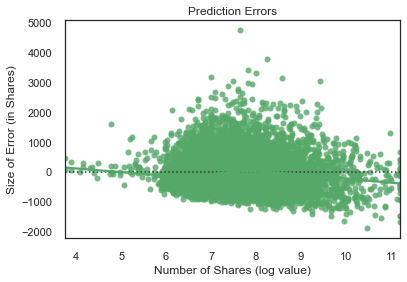

In [59]:
sns.residplot(y_test, y_pred, lowess=True, color="g")

plt.title('Prediction Errors')
plt.xlabel('Number of Shares (log value)')
plt.ylabel('Size of Error (in Shares)')

## F-Test model

In [60]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=6)

selector.fit(X_train, y_train)

selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [61]:
selected_columns

Index(['LDA_02', 'log_kw_max_avg', 'log_kw_avg_avg', 'avg_token_length_LDA_02',
       'num_links_log_self_ref_avg_shares', 'LDA_02_log_kw_avg_avg'],
      dtype='object')

In [62]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = np.exp(lm_kbest.predict(X_train[selected_columns]))


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = np.exp(lm_kbest.predict(X_test[selected_columns]))

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)


print('Original: ', test_rmse, "vs. KBest: ", testK_rmse)

Training Root Mean Squared Error: 1876.7571130293911
Testing Root Mean Squared Error: 1868.2058854680924
Original:  1973.0464759606577 vs. KBest:  1868.2058854680924


In [63]:
trainK_mae = metrics.mean_absolute_error(y_train, y_train_kbest)
testK_mae = metrics.mean_absolute_error(y_test, y_kbest)
print('Training Mean Absolute Error:' , trainK_mae)
print('Testing Mean Absolute Error:' , testK_mae)

Training Mean Absolute Error: 1816.7901495748536
Testing Mean Absolute Error: 1808.0401610435065


Text(0, 0.5, 'Size of Error (in Shares)')

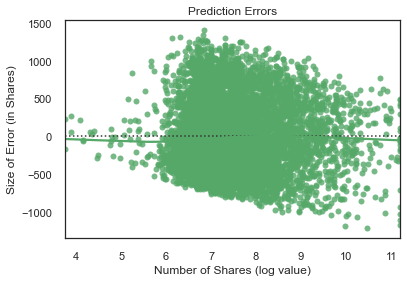

In [64]:
sns.residplot(y_test, y_kbest, lowess=True, color="g")

plt.title('Prediction Errors')
plt.xlabel('Number of Shares (log value)')
plt.ylabel('Size of Error (in Shares)')

## Lasso model

Training Error: 1813.0667581226783
Testing Error: 1809.8423422627257


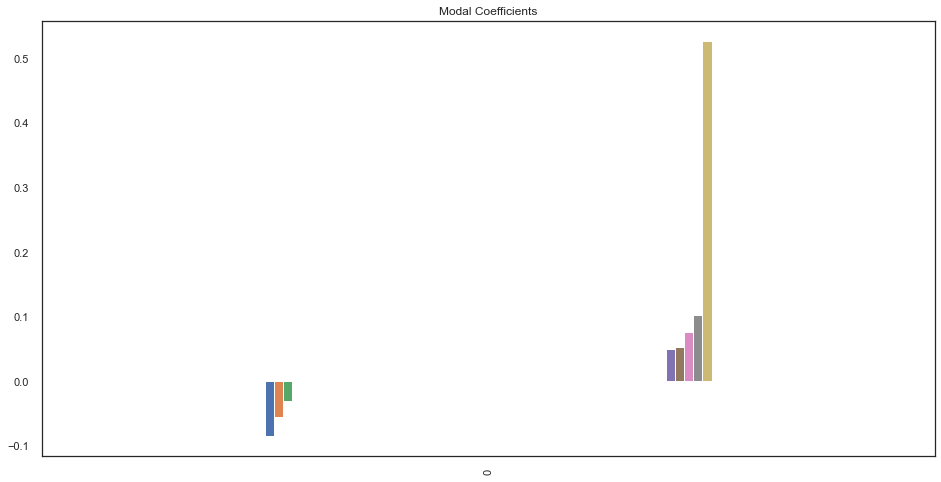

In [65]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=.02, normalize=False)

lasso.fit(X_train,y_train)

y_train_pred_lasso = np.exp(lasso.predict(X_train))
y_pred_lasso = np.exp(lasso.predict(X_test))

train_lasso_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred_lasso))
test_lasso_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso))
print('Training Error: '+ str(train_lasso_rmse) )
print('Testing Error: '+ str(test_lasso_rmse) )

lasso_coef01 = pd.DataFrame(data=lasso.coef_).T
lasso_coef01.columns = X_train.columns
lasso_coef01 = lasso_coef01.T.sort_values(by=0).T
lasso_coef01.plot(kind='bar', title='Modal Coefficients', legend=False, figsize=(16,8))

In [66]:
train_lasso_mae = metrics.mean_absolute_error(y_train, y_train_pred_lasso)
test_lasso_mae = metrics.mean_absolute_error(y_test, y_pred_lasso)
print('Training Mean Absolute Error:' , train_lasso_mae)
print('Testing Mean Absolute Error:' , test_lasso_mae)

Training Mean Absolute Error: 1784.921428233401
Testing Mean Absolute Error: 1781.1693651078072


In [67]:
coefficient = lasso_coef01.T
coefficient[coefficient[0] != 0]

,0
entertainment,-0.084632
LDA_02_log_kw_min_avg,-0.055309
avg_token_length_LDA_02,-0.031224
tech,0.049231
log_kw_max_avg,0.053674
num_links_log_self_ref_avg_shares,0.075796
is_weekend,0.102000
log_kw_avg_avg,0.527816


Text(0, 0.5, 'Size of Error (in Shares)')

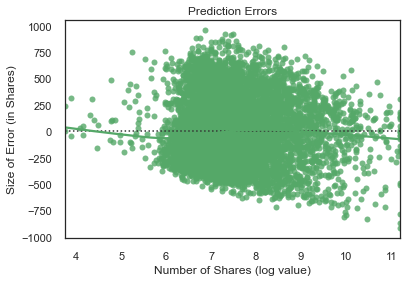

In [68]:
sns.residplot(y_test, y_pred_lasso, lowess=True, color="g")

plt.title('Prediction Errors')
plt.xlabel('Number of Shares (log value)')
plt.ylabel('Size of Error (in Shares)')

## Final Results of Prediction Models

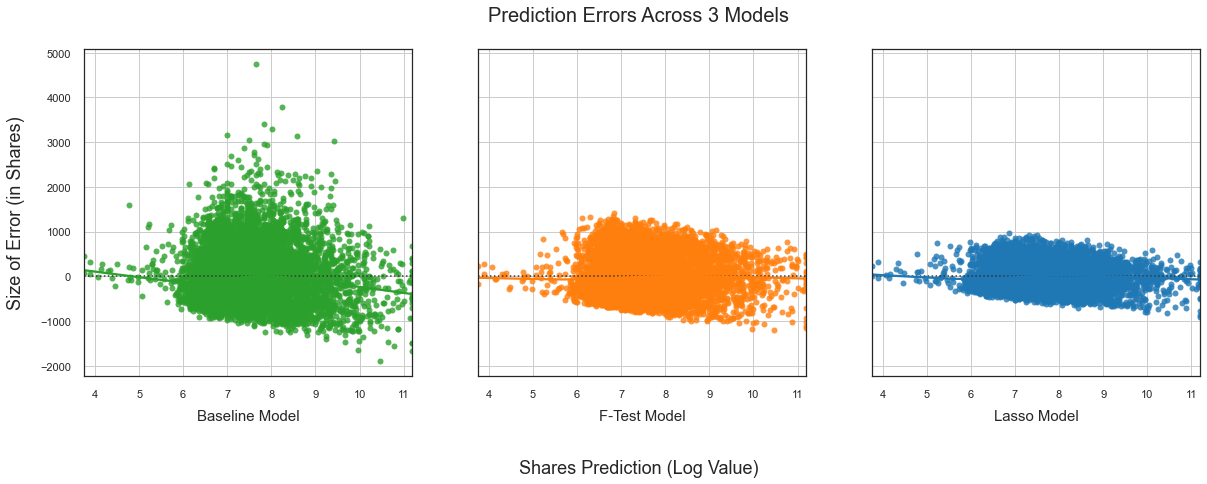

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(20,6))

sns.residplot(y_test, y_pred, lowess=True, color="tab:green", ax=ax1)
sns.residplot(y_test, y_kbest, lowess=True, color="tab:orange", ax=ax2)
sns.residplot(y_test, y_pred_lasso, lowess=True, color="tab:blue", ax=ax3)

plt.suptitle('Prediction Errors Across 3 Models', fontsize=20, x=.51)

fig.text(0.51, -.1, 'Shares Prediction (Log Value)', ha='center', fontsize=18)

ax1.set_xlabel('Baseline Model', fontsize=15, labelpad=10)
ax2.set_xlabel('F-Test Model', fontsize=15, labelpad=10)
ax3.set_xlabel('Lasso Model', fontsize=15, labelpad=10)

ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

ax1.set_ylabel('Size of Error (in Shares)', fontsize=18, labelpad=15)

ax3.yaxis.set_label_position("right")

* Unfortunately, our predictions seem to be off by about 8 standard deviations. Not the most predictive of models.

In [70]:
np.log(test_mae)/y_test.std()

8.174608814813173

## Findings
* Title length, article length, and average length of words do not have a significant impact on an article's popularity.
* Genres do have noticeably different average shares, with Lifestyle and Social Media articles receiving the most, followed by Tech, Entertainment, and Business articles. World News articles considerably performed the worst.
* Articles published on the weekend perform significantly better than articles published during the weekdays. There is, however, no significant difference between articles published on a specific day within those two categories.
* Measures of sentiment (positivity, negativity, and neutrality), as well as measures of subjectivity, have no significant impact on an article's popularity.
* The average number of shares for the average performance of all keywords used in an article's SEO terms has the highest impact on an article's popularity and thus has the most predictive power.

### Strongest coefficients (in order)
* The average of all the shares associated with all of the keywords in the SEO metadata.
    * There is a logarithmic relationship between the two, as average shares of your keywords go up, shares for your article increases at half that rate.
* Whether the article was published on the weekend.
    * On average, articles on the weekend have .1 more shares than articles published during the week.
* Whether the article was part of the Entertainment news channel.
    * On average, articles published in the Entertainment channel have .08 fewer shares than articles published in other channels.

# Final conclusion
* It is difficult to predict the popularity of an online news article using a linear regression model. Values for SEO metadata (keywords) proved to be the most represented predictors in this model, followed by genre and whether or not an article was published on the weekend. The model found some success with interaction terms, namely type of content combined with keywords and word length.The model is homoscedastic, meaning there is a fairly equal variance throughout. Still, the average error from the mean is about 8 standard deviations, meaning this is not a very successful predictive model. 